In [ ]:
from delphi import Expert
from models import LLMFactory, LLMProvider, LLMModel
from dataset.dataloader import ForecastDataLoader

from eval import load_config
import os

import random
import copy
import asyncio
import nest_asyncio

from collections import defaultdict

import openai

import time

nest_asyncio.apply()

config_path = '/home/williaar/projects/delphi/configs/config_openai.yml'
config = load_config(config_path)



provider = LLMProvider.OPENAI
model = LLMModel.GPT_4O
personalized_system_prompt = "You are a helpful assistant with expertise in forecasting and decision-making."

api_key = 'REDACTED'

os.environ["OPENAI_API_KEY"] = api_key

llm = LLMFactory.create_llm(provider, model, system_prompt=personalized_system_prompt)

# get questions that have a topic
loader = ForecastDataLoader()
questions_with_topic = loader.get_questions_with_topics()

forecast_due_date = "2024-07-21"  # Example date, adjust as needed
n_samples = 5
selected_dates = ['2034-07-19']
# selected_dates = ['2025-07-21', '2027-07-21', '2029-07-20', '2034-07-19']

def ts():
    return time.strftime("%H:%M:%S")

async def debug_wrapper(coro, label):
    print(f"[{ts()}] Starting {label}")
    result = await coro
    print(f"[{ts()}] Finished {label}")
    return result


import asyncio

def dump_tasks():
    for t in asyncio.all_tasks():
        if t is not asyncio.current_task():
            print(f"Pending: {t.get_coro()} - {t}")

asyncio.get_event_loop().call_later(30, dump_tasks)


<TimerHandle when=444454.485352639 dump_tasks() at /tmp/ipykernel_179544/1553680745.py:57>

Pending: <coroutine object Kernel.dispatch_queue at 0x789807c96dc0> - <Task pending name='Task-2' coro=<Kernel.dispatch_queue() running at /home/williaar/projects/delphi/delphiEnv/lib/python3.12/site-packages/ipykernel/kernelbase.py:516> wait_for=<Future pending cb=[Task.task_wakeup()]> cb=[_wrap_awaitable.<locals>.<lambda>() at /home/williaar/projects/delphi/delphiEnv/lib/python3.12/site-packages/tornado/gen.py:854, IOLoop.add_future.<locals>.<lambda>() at /home/williaar/projects/delphi/delphiEnv/lib/python3.12/site-packages/tornado/ioloop.py:707]>


In [16]:
async def forecast_entry(q, date, n_samples=n_samples):
    expert = Expert(llm, user_profile=None, config=config.get('model', {}))
    q_instance = copy.copy(q)
    q_instance.resolution_date = date
    q_instance.question = q.question.replace("{resolution_date}", date)
    q_instance.question = q_instance.question.replace("{forecast_due_date}", forecast_due_date)

    # Parallel forecast generation
    forecast_tasks = [expert.forecast(q_instance, None) for _ in range(n_samples)]
    forecasts = await asyncio.gather(*forecast_tasks)

    return {
        'date': date,
        'text': q_instance.question,
        'forecasts': forecasts,
        'full_conversation': expert.conversation_manager.messages  # watch out for race conditions
    }

async def throttled_forecast_entry(q, date, semaphore, wait_time=30, retries=10):
    async with semaphore:
        for attempt in range(1, retries + 1):
            try:
                return await forecast_entry(q, date, n_samples=n_samples)
            except openai.RateLimitError as e:
                if attempt < retries:
                    sleep_time = wait_time * (2 ** (attempt - 1))
                    print(f"[{q.id}] Rate limit hit (attempt {attempt}) — sleeping {sleep_time}s")
                    await asyncio.sleep(sleep_time)
                else:
                    print(f"[{q.id}] Rate limit error after {retries} attempts. Giving up.")
                    return {
                    'date': date,
                    'text': q.question,
                    'forecasts': [],
                    'full_conversation': [],
                    'error': 'rate_limit_exceeded'
                    }

async def run_all_forecasts(questions):

    semaphore = asyncio.Semaphore(5)

    async def forecast_question(q):
        tasks = [throttled_forecast_entry(q, date, semaphore) for date in selected_dates]
        entries = await asyncio.gather(*tasks)
        return q.id, {
            'question': q,
            'entries': entries
        }

    all_tasks = [forecast_question(q) for q in questions]
    results = await asyncio.gather(*all_tasks)

    return dict(results)


In [ ]:
# # async def run_all_forecasts_for_all_superforecasters_with_examples(questions, max_examples=5):

# #     semaphore = asyncio.Semaphore(1)

# #     async def forecast_question(q):

# #         tasks = []
# #         for date in selected_dates:
# #             qa_pairs_for_date, _ = find_example_questions(q, loader, date)
# #             qa_pairs_for_date = qa_pairs_for_date[:max_examples]
# #             tasks.append(
# #                 asyncio.wait_for(
# #                     throttled_forecast_entry_with_examples(q, date, qa_pairs_for_date, semaphore),
# #                     timeout=300  # long enough for retries
# #                 )
# #             )

# #         entries = await asyncio.gather(*tasks)
# #         return q.id, {
# #             'question': q,
# #             'entries': entries
# #         }

# #     all_tasks = [forecast_question(q) for q in questions]
# #     results = await asyncio.gather(*all_tasks)

# #     return dict(results)


# def find_example_questions(question, loader, selected_date, strategy='most_questions'):

#     user_to_questions = find_topic_relevant_users(question, loader, selected_date)

#     if not user_to_questions:
#         print(f"No relevant users found for question {question.id}.")
#         return [], None

#     # Print out the questions grouped by user
#     # for user_id, questions in user_to_questions.items():
#     #     print(f"User {user_id}: {len(questions)} questions")
#     #     for q in questions:
#     #         print(f"  Question ID: {q.id}")

#     qa_pairs = []

#     if strategy == 'most_questions':
#         # Find the user with the most questions
#         max_user = max(user_to_questions.items(), key=lambda x: len(x[1]))[0]
#         max_user_questions = user_to_questions[max_user]
#         qa_pairs = get_super_forecasts_by_user(max_user, max_user_questions, loader, selected_date)

#     elif strategy == 'random':
#         eligible_users = [user_id for user_id, qs in user_to_questions.items() if len(qs) >= 5]
#         if eligible_users:
#             chosen_user = random.choice(eligible_users)
#             chosen_user_questions = user_to_questions[chosen_user]
#             qa_pairs = get_super_forecasts_by_user(chosen_user, chosen_user_questions, loader, selected_date)

#     # qa_pairs now contains tuples of (question, forecast) for one superforecaster

#     random.seed(42)
#     random.shuffle(qa_pairs)

#     return qa_pairs, max_user

# def find_topic_relevant_users(question, loader, selected_date, cutoff=5):
#     print(f"Finding topic-relevant users for {question.id}...")
#     example_questions = loader.get_same_topic_questions(question.id)

#     # Collect all forecasts for each user across all example questions
#     user_to_questions = defaultdict(list)

#     for q in example_questions:
#         super_forecasts = loader.get_super_forecasts(question_id=q.id, selected_date=selected_date)
#         for sf in super_forecasts:
#             user_to_questions[sf.user_id].append(q)

#     # Filter users with at least `cutoff` questions
#     relevant_users = {user_id: qs for user_id, qs in user_to_questions.items() if len(qs) >= cutoff}
#     # print(f"Found {len(relevant_users)} relevant users with at least {cutoff} questions.")

#     return relevant_users

# def get_super_forecasts_by_user(user_id, questions, loader, selected_date):
#     user_forecasts = []
#     for q in questions:
#         forecasts = loader.get_super_forecasts(question_id=q.id, selected_date=selected_date)
#         user_forecast = next((sf for sf in forecasts if sf.user_id == user_id), None)
#         if user_forecast:
#             user_forecasts.append((q, user_forecast))
#     return user_forecasts


In [17]:
def sample_questions_by_topic(questions, n_per_topic=3, seed=42):
    random.seed(seed)
    # Collect all unique topics
    unique_topics = set(q.topic for q in questions)
    topic_to_questions = defaultdict(list)
    # Shuffle questions to randomize selection
    shuffled_questions = random.sample(questions, len(questions))
    for topic in unique_topics:
        topic_questions = [q for q in shuffled_questions if q.topic == topic]
        topic_to_questions[topic] = topic_questions[:n_per_topic]
    # Only include topics that have at least n_per_topic questions
    for topic in unique_topics:
        topic_questions = [q for q in shuffled_questions if q.topic == topic]
        if len(topic_questions) < n_per_topic:
            raise ValueError(f"Topic '{topic}' only has {len(topic_questions)} questions, but {n_per_topic} are required.")
        topic_to_questions[topic] = topic_questions[:n_per_topic]
    sampled_questions = [q for qs in topic_to_questions.values() if len(qs) == n_per_topic for q in qs]
    return sampled_questions

sampled_questions = sample_questions_by_topic(questions_with_topic, n_per_topic=3)


In [18]:
async def run_all_forecasts_for_all_superforecasters_with_examples(
    sampled_questions, *, max_examples=5
):
    all_examples = _collect_example_forecasts(sampled_questions, loader, selected_dates)

    for qid in all_examples:
        for sf_id in all_examples[qid]:
            all_examples[qid][sf_id] = all_examples[qid][sf_id][:max_examples]

    semaphore = asyncio.Semaphore(5)
    tasks = [
        asyncio.wait_for(task, timeout=300)  # 5 min per forecast
        for task in _build_tasks(sampled_questions, all_examples, semaphore)
    ]
    results = await asyncio.gather(*tasks, return_exceptions=True)
    return results

def _collect_example_forecasts(sampled_questions, loader, selected_dates, *, max_examples=5):
    """
    Return {question_id: {sf_id: example_pairs}}, where each example pair is
    (question_obj, forecast_obj) — the same shape expected by
    `throttled_forecast_entry_with_examples`.
    """
    # quick lookup for already-loaded Question objects
    questions_by_id = {q.id: q for q in sampled_questions}

    example_forecasts_dict = {}
    for q in sampled_questions:
        sf_ids = [
            f.user_id
            for f in loader.get_super_forecasts(
                question_id=q.id, resolution_date=selected_dates[0]
            )
        ]
        if not sf_ids:
            print(f"No superforecasters found for question {q.id}.")
            continue

        example_forecasts_dict[q.id] = {}
        for sf_id in sf_ids:
            forecasts = loader.get_super_forecasts(
                user_id=sf_id,
                resolution_date=selected_dates[0],
                topic=q.topic,
            )

            example_pairs = []
            for f in forecasts:
                if getattr(f, "id", None) == q.id:
                    continue  # skip the target question itself
                q_obj = loader.get_question(f.id)          # ← direct lookup
                example_pairs.append((q_obj, f))
                if len(example_pairs) >= max_examples:
                    break

            example_forecasts_dict[q.id][sf_id] = example_pairs

    return example_forecasts_dict

def _build_tasks(sampled_questions, all_examples, semaphore):
    for q in sampled_questions:
        for sf_id, pair in all_examples.get(q.id, {}).items():
            yield _forecast_one(q, sf_id, pair, semaphore)

async def _forecast_one(question, sf_id, example_forecasts, semaphore):
    return question.id, sf_id, {
        "question": question,
        "forecast": await throttled_forecast_entry_with_examples(
            question, selected_dates[0], example_forecasts, semaphore
        ),
        "superforecaster_id": sf_id,
        "example_pairs": example_forecasts,
    }

async def throttled_forecast_entry_with_examples(q, date, qa_pairs, semaphore, wait_time=30, retries=10):
    async with semaphore:
        for attempt in range(1, retries + 1):
            try:
                return await forecast_entry_with_examples(q, date, qa_pairs, n_samples=n_samples)
            except Exception as e:
                if attempt < retries:
                    sleep_time = wait_time * (2 ** (attempt - 1))
                    print(f"[{q.id}] Rate limit hit (attempt {attempt}) — sleeping {sleep_time}s")
                    await asyncio.sleep(sleep_time)
                else:
                    print(f"[{q.id}] Rate limit error after {retries} attempts. Giving up.")
                    return {
                        'date': date,
                        'text': q.question,
                        'forecasts': [],
                        'full_conversation': [],
                        'error': 'rate_limit_exceeded'
                    }

async def forecast_entry_with_examples(q, date, qa_pairs, n_samples=n_samples):
    expert = Expert(llm, user_profile=None, config=config.get('model', {}))
    q_instance = copy.copy(q)
    q_instance.resolution_date = date
    q_instance.question = q.question.replace("{resolution_date}", date)
    q_instance.question = q_instance.question.replace("{forecast_due_date}", forecast_due_date)

    retries = 5
    wait_time = 10

    async def call_with_retry():
            for attempt in range(1, retries+1):
                try:
                    return await expert.forecast_with_examples_in_context(q_instance, qa_pairs)
                except openai.RateLimitError as e:
                    if attempt < retries:
                        await asyncio.sleep(wait_time * (2 ** (attempt-1)))
                    else:
                        raise

    forecast_tasks = [call_with_retry() for _ in range(n_samples)]
    forecasts = await asyncio.gather(*forecast_tasks)
    return {
        'date': date,
        'text': q_instance.question,
        'forecasts': forecasts,
        'full_conversation': expert.conversation_manager.messages
    }


In [19]:
import pickle
import os

for q in sampled_questions[::3]:
    if os.path.exists(f'collected_fcasts_{q.id}.pkl'):
        print(f"Pickle for question {q.id} already exists, skipping.")
        continue
    print(f"Collecting forecasts for question {q.id}...")
    results = await run_all_forecasts_for_all_superforecasters_with_examples([q])
    with open(f'collected_fcasts_{q.id}.pkl', 'wb') as f:
        pickle.dump(results, f)
    print(f"Collected forecasts for question {q.id}.")


print("All forecasts collected and saved to pickle files.")

Pickle for question T10YIE already exists, skipping.
Pickle for question eda8e5b43e0db651905667586e1e72a7d5679cbb5b3ef4dd6faa6444759e2dee already exists, skipping.
Pickle for question SNA already exists, skipping.
Pickle for question meteofrance_TEMPERATURE_celsius.78890.D already exists, skipping.
Pickle for question 61c0fb3703e68cee2439afd5c2d71522bc6649a1fa154491f58981456fa8ab68 already exists, skipping.
Pickle for question TPR already exists, skipping.
Pickle for question e53dabd31f71786f3b044bd12e498deee5a732a43de2d9be7468ebaced466977 already exists, skipping.
All forecasts collected and saved to pickle files.


In [21]:
import pickle
import os

def load_collected_forecasts(sampled_questions):
    all_forecasts = []
    for q in sampled_questions[::3]:
        fname = f'collected_fcasts_{q.id}.pkl'
        if os.path.exists(fname):
            try:
                with open(fname, 'rb') as f:
                    forecasts = pickle.load(f)
                    all_forecasts.extend(forecasts)
            except TypeError as e:
                print(f"Could not load {fname}: {e}")
        else:
            print(f"Warning: Pickle file {fname} not found.")
    return all_forecasts
llmcasts_experts = load_collected_forecasts(sampled_questions)

nested_llmcasts = {}
for qid, sfid, data in llmcasts_experts:
    if qid not in nested_llmcasts:
        nested_llmcasts[qid] = {}
    nested_llmcasts[qid][sfid] = data
nested_llmcasts

{'T10YIE': {'SUpgMvejGk': {'question': Question(id='T10YIE', source='fred', question="Will the US' 10-year breakeven inflation rate have increased by {resolution_date} as compared to its value on {forecast_due_date}?", resolution_criteria='Resolves to the value found at https://fred.stlouisfed.org/series/T10YIE once the data is published.', background='The notes from the release: N/A.  The notes from the series: The breakeven inflation rate represents a measure of expected inflation derived from 10-Year Treasury Constant Maturity Securities (BC_10YEAR) and 10-Year Treasury Inflation-Indexed Constant Maturity Securities (TC_10YEAR). The latest value implies what market participants expect inflation to be in the next 10 years, on average.\nStarting with the update on June 21, 2019, the Treasury bond data used in calculating interest rate spreads is obtained directly from the U.S. Treasury Department (https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView

In [22]:
actual_superforecasts = {}

for qid, sf_dict in nested_llmcasts.items():
    actual_superforecasts[qid] = {}
    for sfid in sf_dict:
        # Get all forecasts for this question and superforecaster
        forecasts = loader.get_super_forecasts(question_id=qid, resolution_date=selected_dates[0], user_id=sfid)
        # Find the forecast from the specific superforecaster
        sf_forecast = next((f for f in forecasts if getattr(f, 'user_id', None) == sfid), None)
        actual_superforecasts[qid][sfid] = sf_forecast

actual_superforecasts

{'T10YIE': {'SUpgMvejGk': Forecast(id='T10YIE', source='fred', forecast=0.49, resolution_date='2034-07-19', reasoning='Pretty consistent data series between 1.5 and 3.0 exccept during financial crises 2008 and 2020.   We may be a bit over the long-term base now  inflation fears have lingered. I  going to guess the intermediate trend is down slightly.', direction=None, user_id='SUpgMvejGk', searches=None, consulted_urls=None),
  'SnOyJtNds8': Forecast(id='T10YIE', source='fred', forecast=0.5, resolution_date='2034-07-19', reasoning='Random walk.', direction=None, user_id='SnOyJtNds8', searches=None, consulted_urls=None),
  'S5CrWZaPfh': Forecast(id='T10YIE', source='fred', forecast=0.52, resolution_date='2034-07-19', reasoning='Affirming forecast after seeing others in the same ballpark.', direction=None, user_id='S5CrWZaPfh', searches=None, consulted_urls=['https://fred.stlouisfed.org/series/T10YIE']),
  'SPqHtpfr8B': Forecast(id='T10YIE', source='fred', forecast=0.5, resolution_date='

# Compare in-context LLM superforecasts to LLM forecast against human superforecasts

7 test questions, 1 per domain randomly sampled from questions with topics

Processing question ID: T10YIE
[0.5, 0.5, 0.5, 0.5, 0.55]
[0.6, 0.55, 0.6, 0.55, 0.6]
[0.65, 0.55, 0.6, 0.5, 0.6]
[0.55, 0.55, 0.55, 0.55, 0.55]


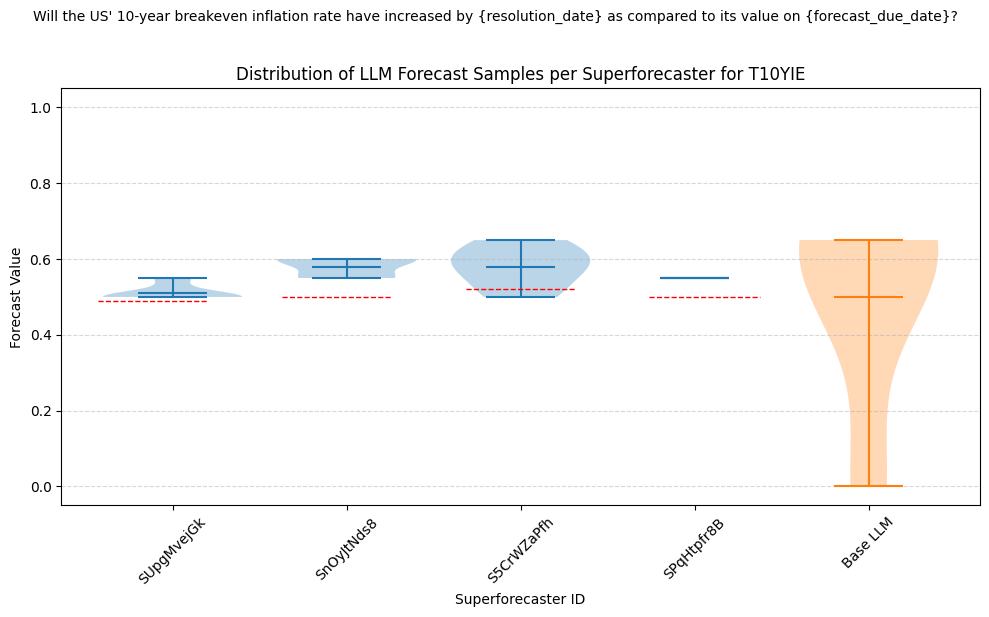

Processing question ID: eda8e5b43e0db651905667586e1e72a7d5679cbb5b3ef4dd6faa6444759e2dee
[0.3, 0.3, 0.3, 0.3, 0.3]
[0.15, 0.25, 0.15, 0.25, 0.25]
[0.3, 0.4, 0.4, 0.3, 0.3]
[0.05, 0.05, 0.05, 0.05, 0.2]
[0.05, 0.05, 0.1, 0.05, 0.05]
[0.2, 0.15, 0.2, 0.15, 0.15]
[0.4, 0.4, 0.15, 0.15, 0.15]


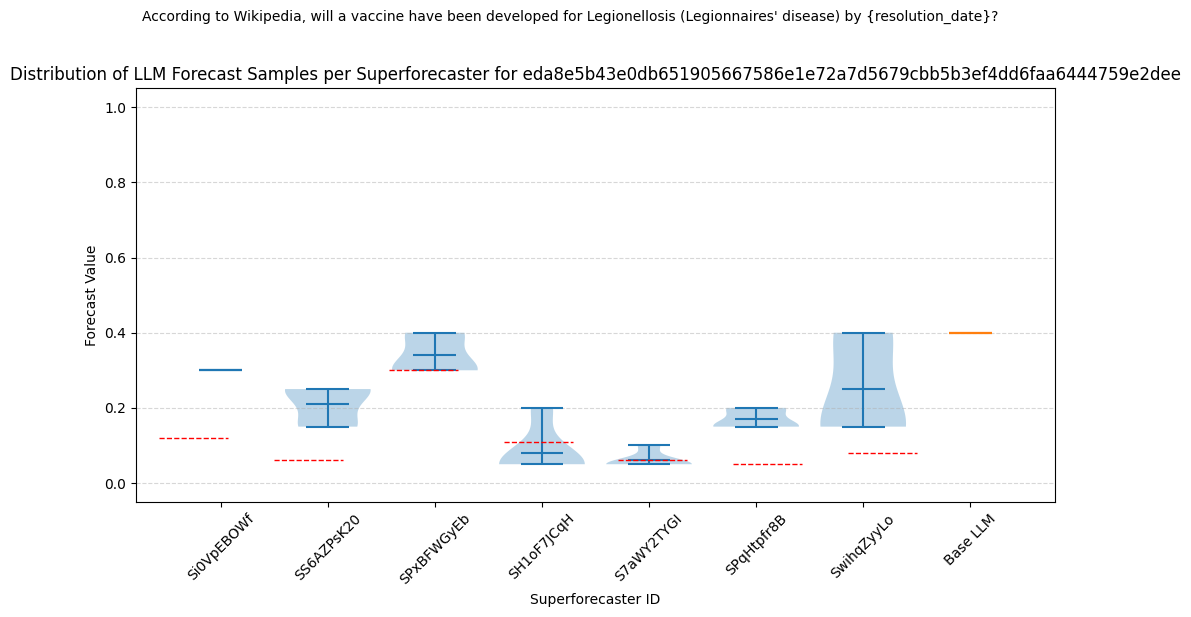

Processing question ID: SNA
[0.62, 0.65, 0.65, 0.65, 0.65]
[0.65, 0.65, 0.7, 0.75, 0.65]
[0.75, 0.75, 0.75, 0.72, 0.75]
[0.5, 0.6, 0.65, 0.5, 0.6]
[0.55, 0.65, 0.6, 0.65, 0.6]
[0.75, 0.75, 0.75, 0.75, 0.75]


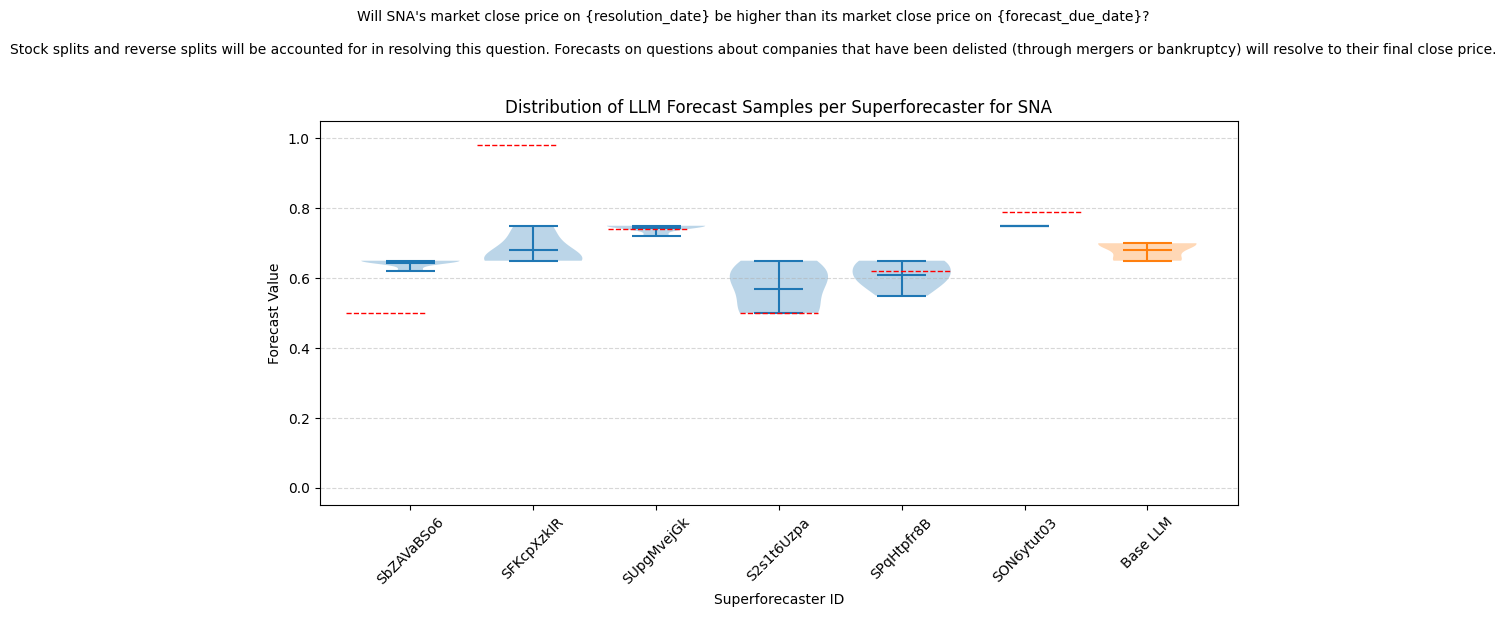

Processing question ID: meteofrance_TEMPERATURE_celsius.78890.D
[0.6, 0.65, 0.65, 0.65, 0.55]
[0.65, 0.6, 0.55, 0.65, 0.65]
[0.56, 0.55, 0.55, 0.55, 0.55]
[0.78, 0.78, 0.78, 0.82, 0.78]
[0.55, 0.53, 0.52, 0.52, 0.52]
[0.55, 0.55, 0.55, 0.5, 0.55]
[0.58, 0.58, 0.58, 0.57, 0.57]
[0.5, 0.51, 0.5, 0.5, 0.51]


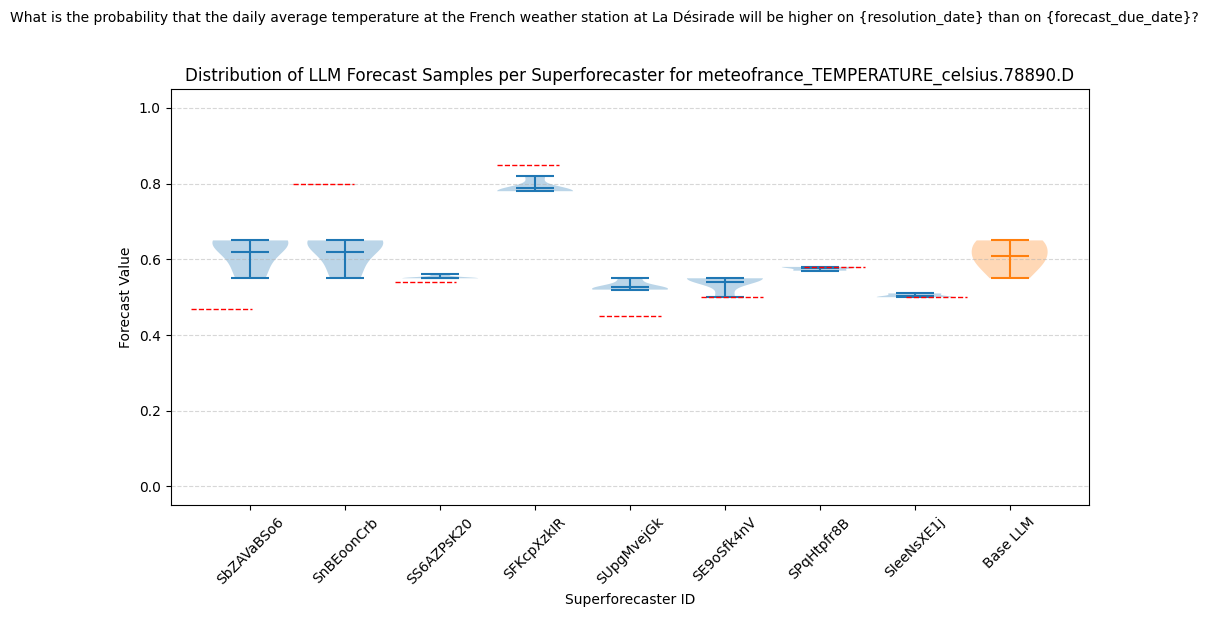

Processing question ID: 61c0fb3703e68cee2439afd5c2d71522bc6649a1fa154491f58981456fa8ab68
[0.25, 0.2, 0.25, 0.25, 0.35]
[0.3, 0.15, 0.35, 0.35, 0.3]
[0.4, 0.4, 0.4, 0.35, 0.35]
[0.4, 0.2, 0.3, 0.2, 0.35]
[0.35, 0.35, 0.1, 0.2, 0.25]
[0.6, 0.25, 0.3, 0.2, 0.2]
[0.3, 0.3, 0.15, 0.3, 0.3]
[0.4, 0.4, 0.2, 0.4, 0.4]
[0.45, 0.35, 0.55, 0.4, 0.4]
[0.35, 0.35, 0.35, 0.35, 0.45]


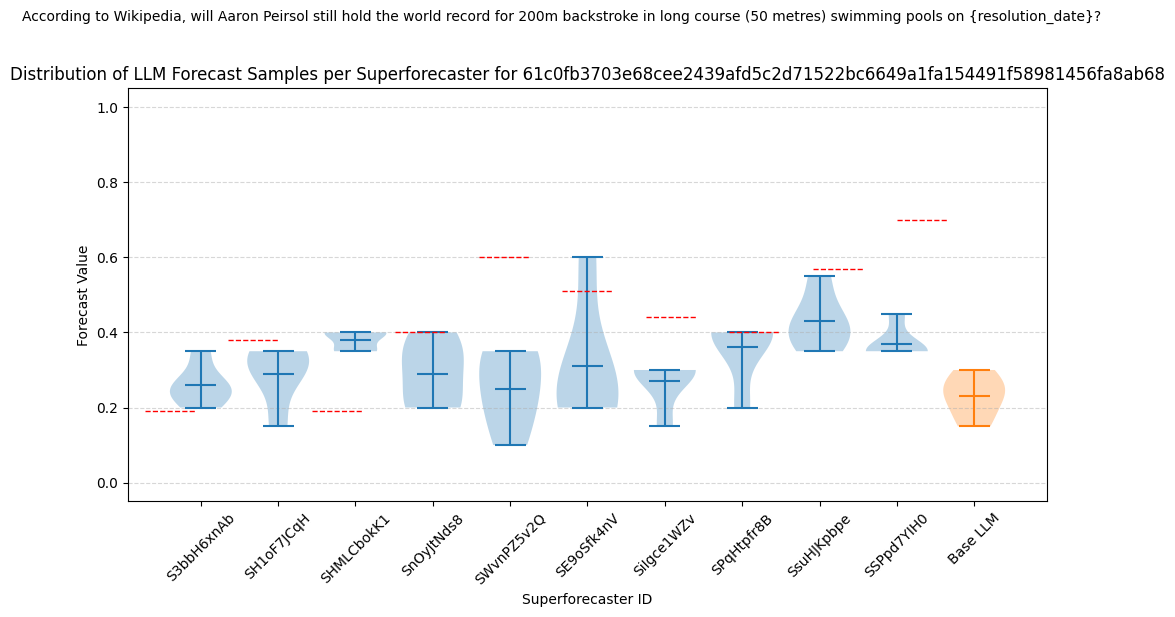

Processing question ID: TPR
[0.6, 0.65, 0.6, 0.65, 0.6]
[0.65, 0.65, 0.65, 0.65, 0.65]
[0.65, 0.65, 0.65, 0.65, 0.65]
[0.6, 0.55, 0.55, 0.55, 0.55]
[0.65, 0.65, 0.65, 0.65, 0.65]


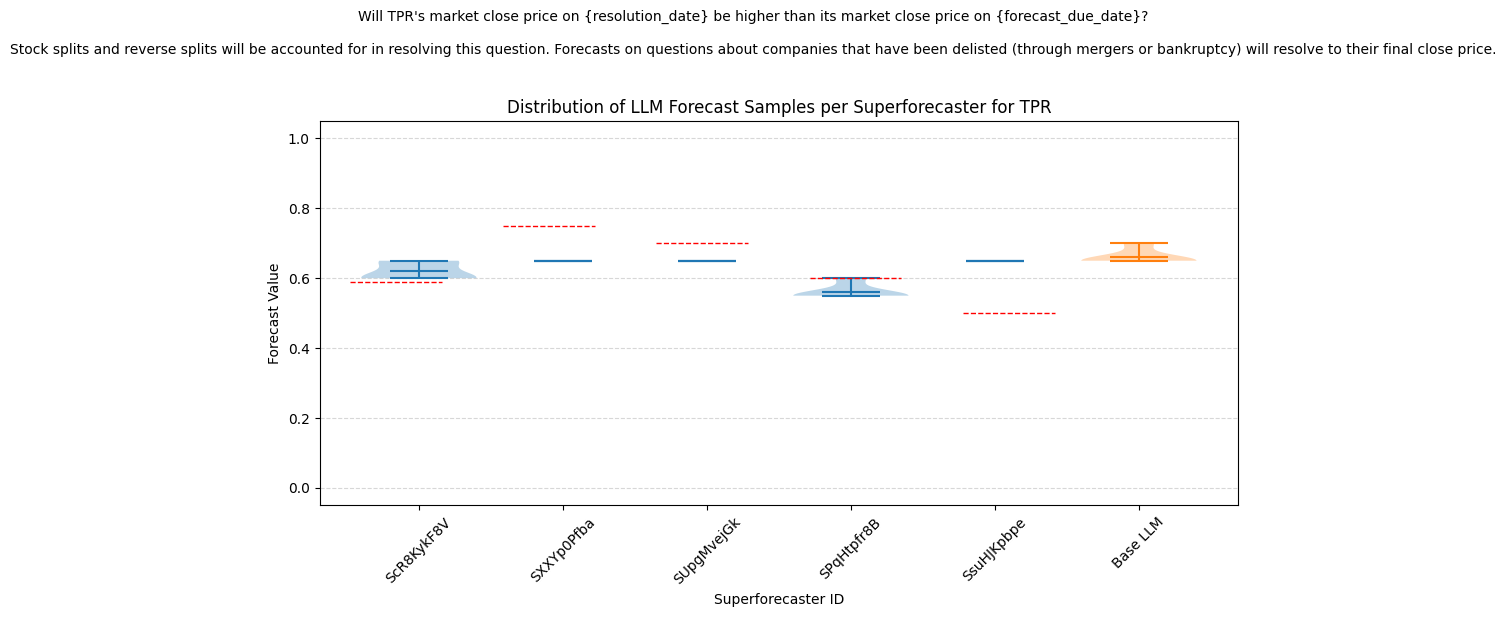

Processing question ID: e53dabd31f71786f3b044bd12e498deee5a732a43de2d9be7468ebaced466977
[0.1, 0.1, 0.25, 0.25, 0.25]
[0.15, 0.15, 0.15, 0.3, 0.15]
[0.45, 0.55, 0.45, 0.35, 0.4]
[0.25, 0.25, 0.4, 0.25, 0.4]
[0.15, 0.15, 0.15, 0.2, 0.1]


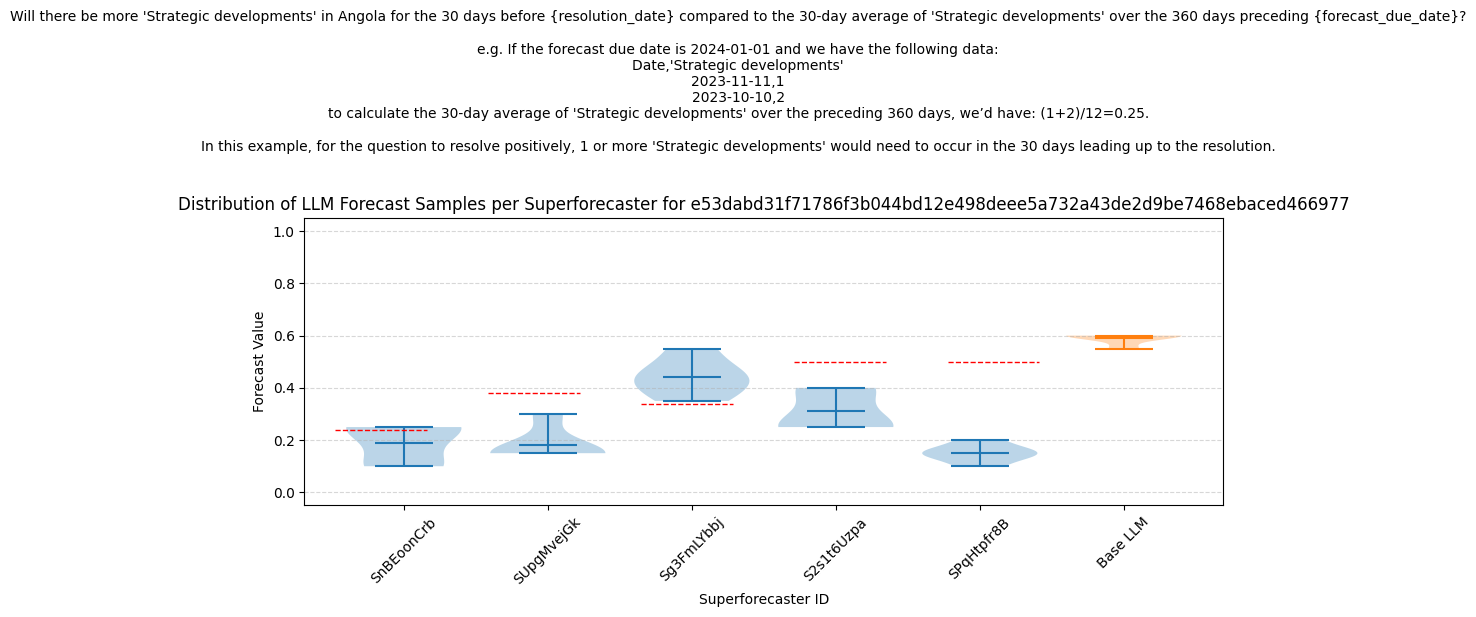

In [14]:
import numpy as np
import json
import matplotlib.pyplot as plt

qid = 'SNA'  # Example question id, adjust as needed

for qid in nested_llmcasts.keys():
    print(f"Processing question ID: {qid}")

    sf_dict = nested_llmcasts[qid]

    plt.figure(figsize=(10, 6))
    llmcasts = []
    labels = []
    ground_truth_casts = []
    plot_data = []
    for idx, (sfid, entry) in enumerate(sf_dict.items()):
        # Extract forecast samples for this superforecaster
        forecasts = entry['forecast']['forecasts']
        print(forecasts)
        # Each forecast may be a dict or object; extract value accordingly
        plot_data.append(forecasts)
        labels.append(sfid)
        # If ground truth is available, extract it
        gt = actual_superforecasts[qid].get(sfid, None).forecast
        if gt is not None:
            ground_truth_casts.append(gt.value if hasattr(gt, 'value') else gt)

    parts = plt.violinplot(plot_data, showmeans=True, widths=0.8)
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=45)

    with open('forecast_results.json', 'r') as f:
        forecast_results = json.load(f)

    entry_base = forecast_results[qid]['entries'][0]
    base_forecasts = [f['forecast'] if isinstance(f, dict) and 'forecast' in f else f for f in entry_base['forecasts']]
    # Add to plot_data and labels
    plot_data.append(base_forecasts)
    labels.append('Base LLM')
    # Plot the new violin
    parts_extra = plt.violinplot([base_forecasts], positions=[len(labels)], showmeans=True, widths=0.8)
    # Color the new violin orange
    if hasattr(parts_extra, 'bodies') and len(parts_extra.bodies) == 1:
        parts_extra.bodies[0].set_facecolor('orange')
        parts_extra.bodies[0].set_edgecolor('orange')
        parts_extra.bodies[0].set_alpha(0.7)
    # Re-set xticks to include the new label
    plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=45)


    # Add ground truth as a red horizontal line for each superforecaster
    for i, gt in enumerate(ground_truth_casts):
        plt.axhline(gt, color='red', linestyle='--', linewidth=1, xmin=(i + 0.2) / len(labels), xmax=(i + 0.8) / len(labels))


    plt.xlabel('Superforecaster ID')
    plt.ylabel('Forecast Value')
    plt.title(f'Distribution of LLM Forecast Samples per Superforecaster for {qid}')
    plt.suptitle(str(sf_dict[list(sf_dict.keys())[0]]['question'].question), fontsize=10, y=1.02)
    plt.ylim(-0.05, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [10]:
import pickle
import json

with open('forecast_results.json', 'r') as f:
    forecast_results = json.load(f)

with open('forecast_results_with_examples.json', 'r') as f:
    forecast_results_with_examples = json.load(f)


In [11]:
from collections import Counter

q_to_forecaster_ids = {}
for q in sampled_questions:
    example_fcasts = loader.get_super_forecasts(resolution_date=selected_dates[0], topic=q.topic)
    # Count forecasts per superforecaster for this topic and date
    sf_counts = Counter(f.user_id for f in example_fcasts)
    most_common_sf = sf_counts.most_common(1)[0][0] if sf_counts else None
    q_to_forecaster_ids[q.id] = most_common_sf

In [ ]:
superforecaster_forecasts = {}

for q in sampled_questions:
    qid = q.id
    superforecaster_id = q_to_forecaster_ids.get(qid)
    superforecaster_forecasts[qid] = loader.get_super_forecasts(question_id=qid, resolution_date=selected_dates[0], user_id=superforecaster_id)[0]

# Compare the base LLM to the in-context LLM forecasts on 20 questions

Only the most expert expert (as judged by number of responses to similar questions) is used to provide examples for each question.

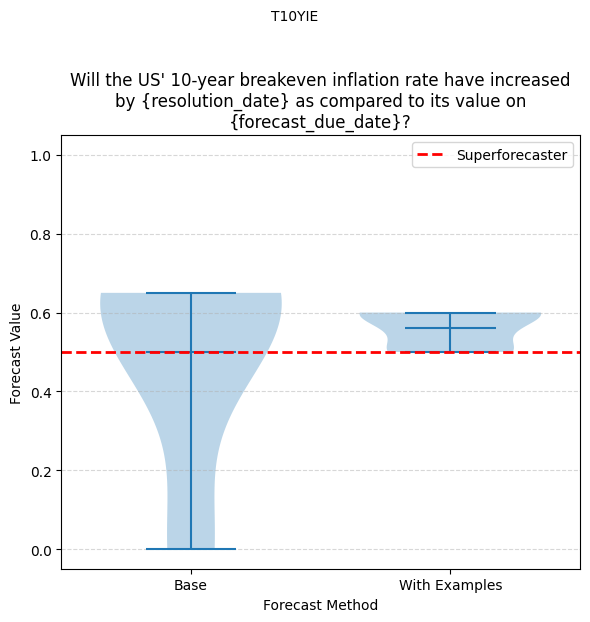

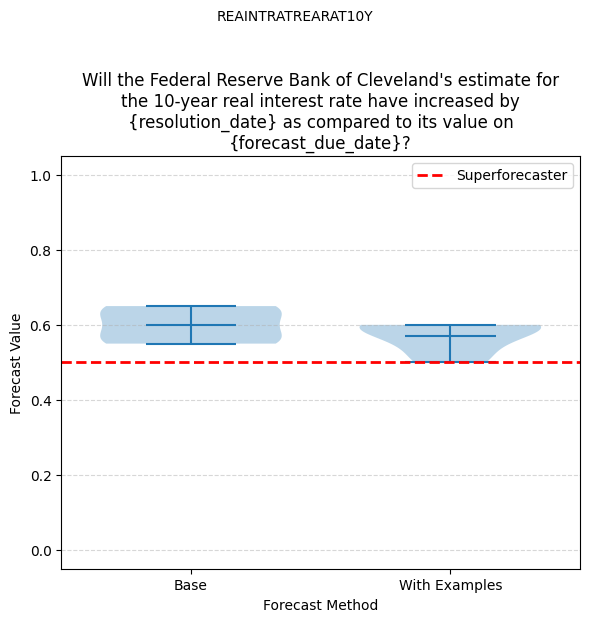

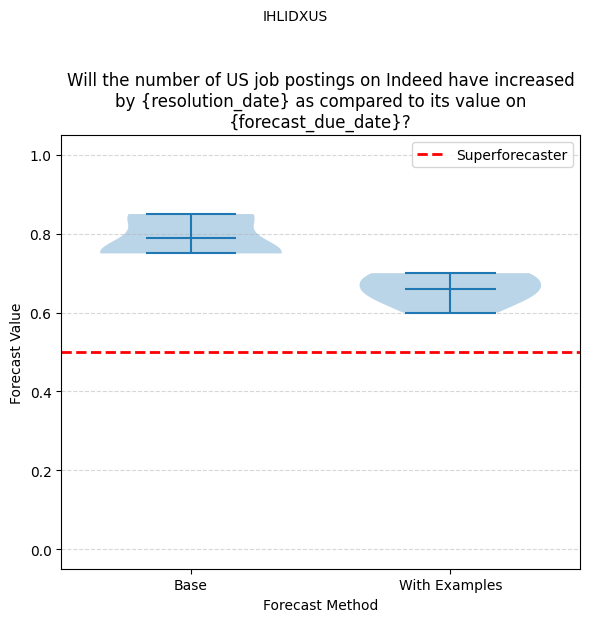

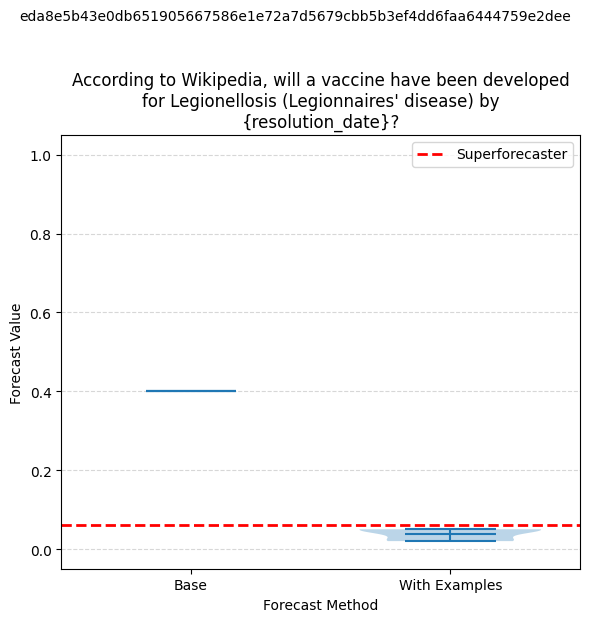

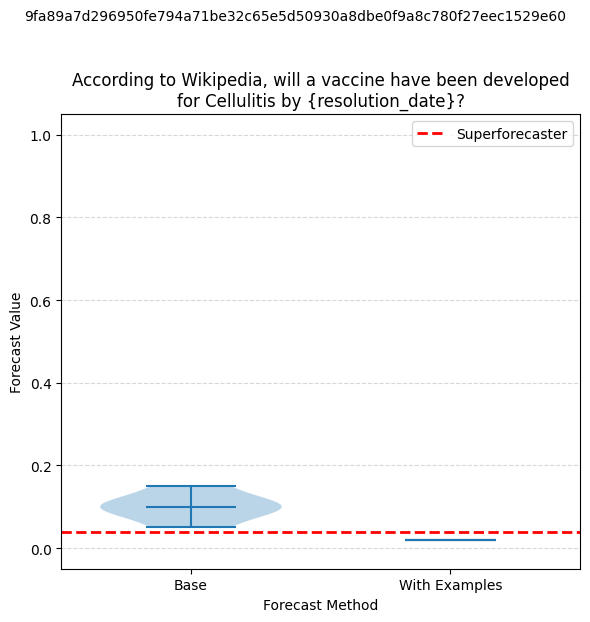

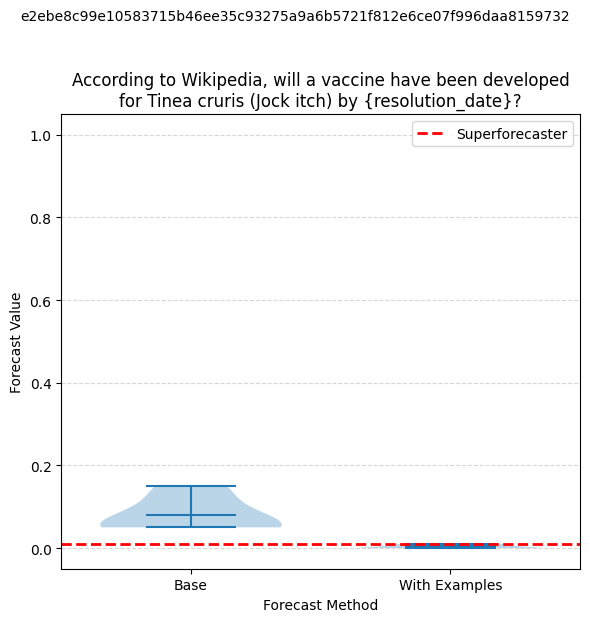

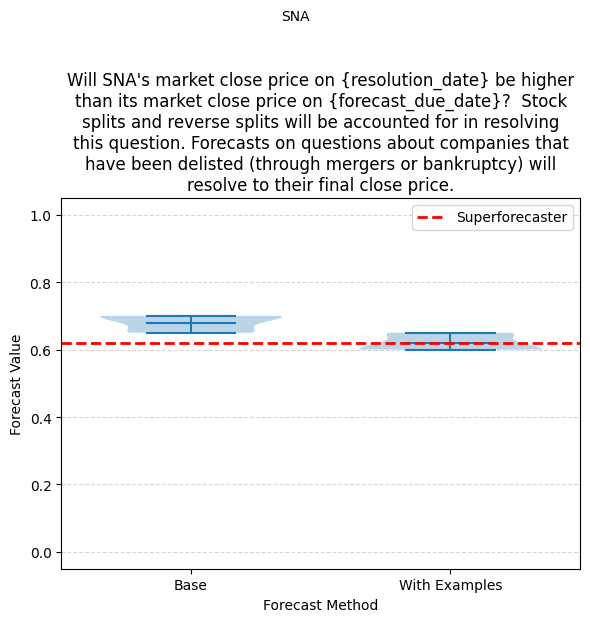

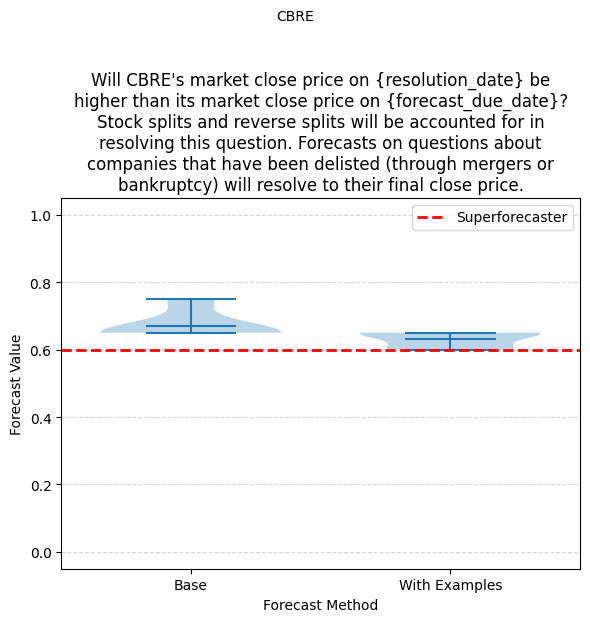

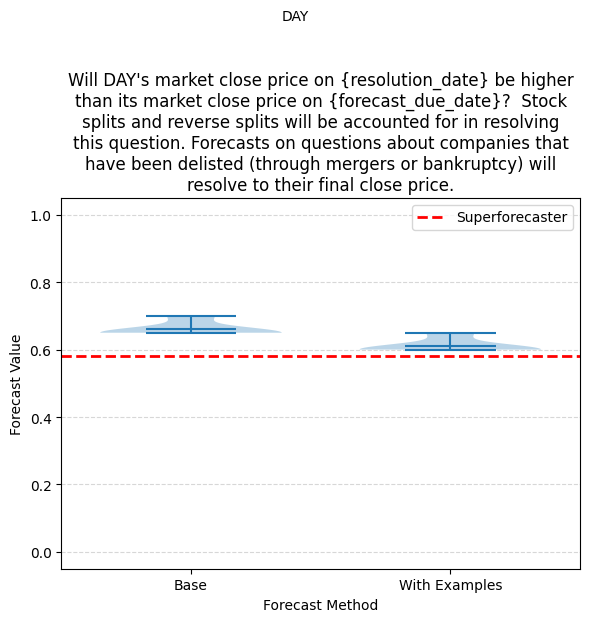

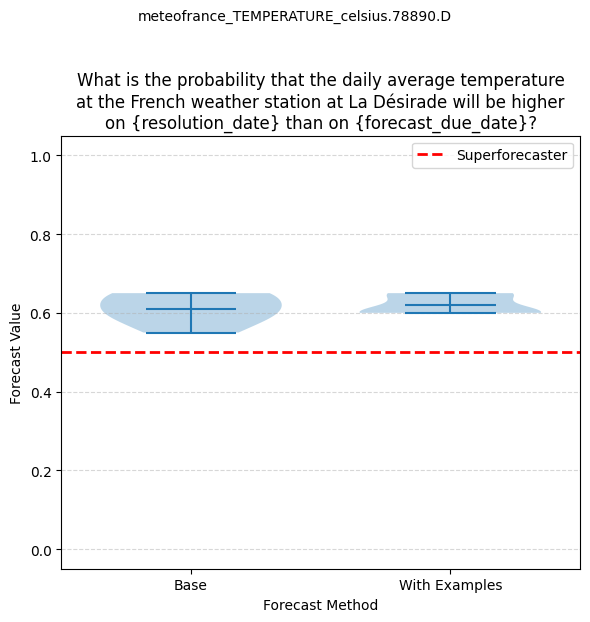

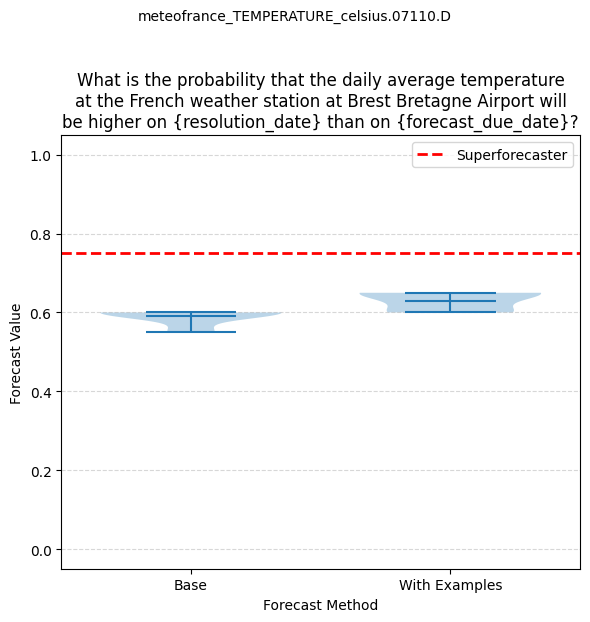

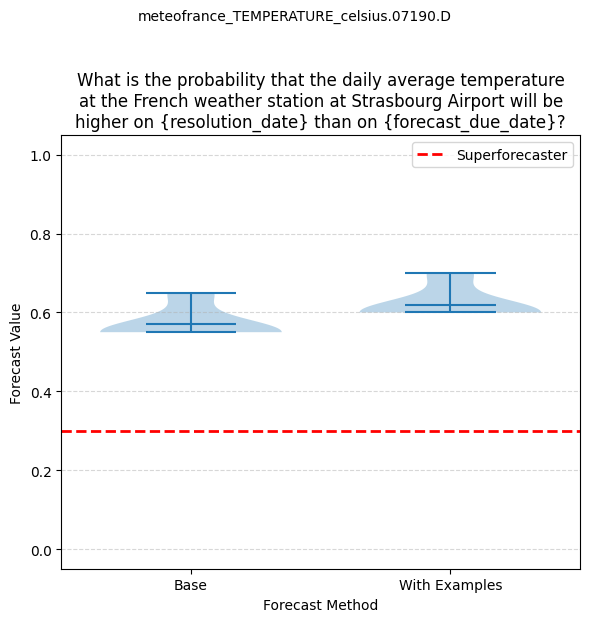

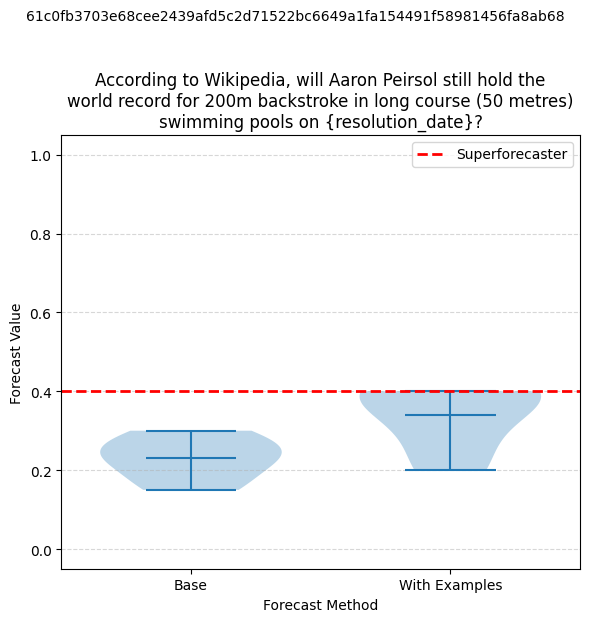

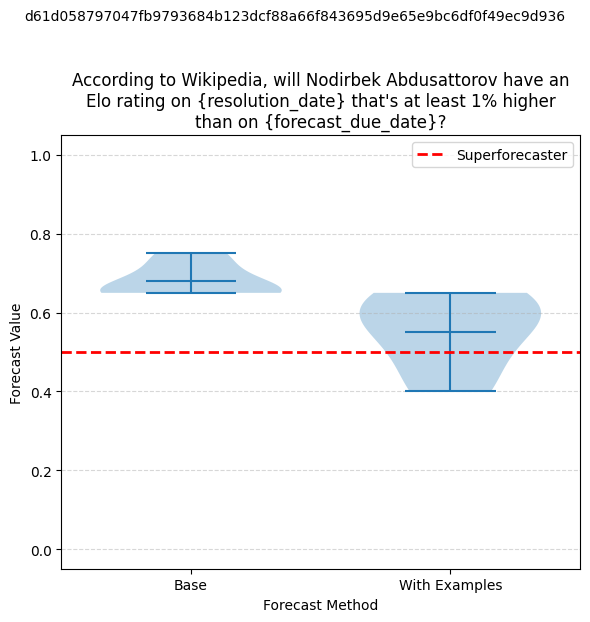

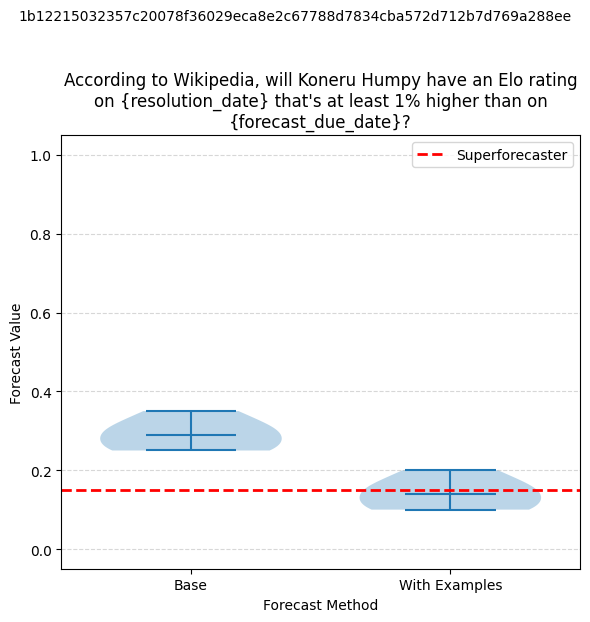

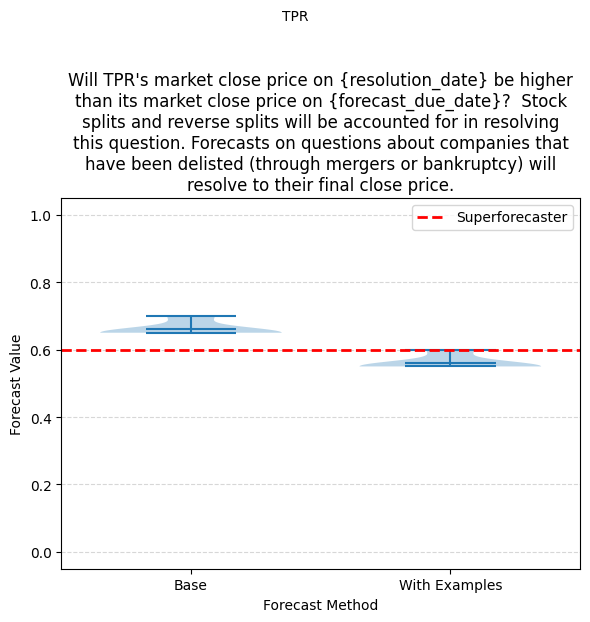

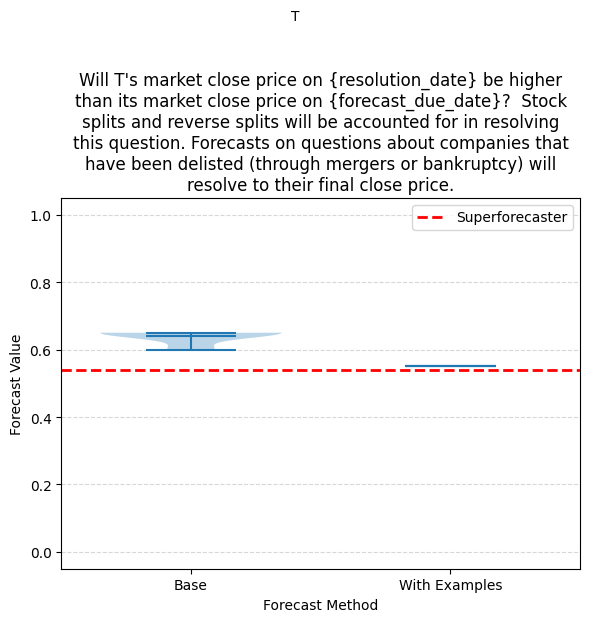

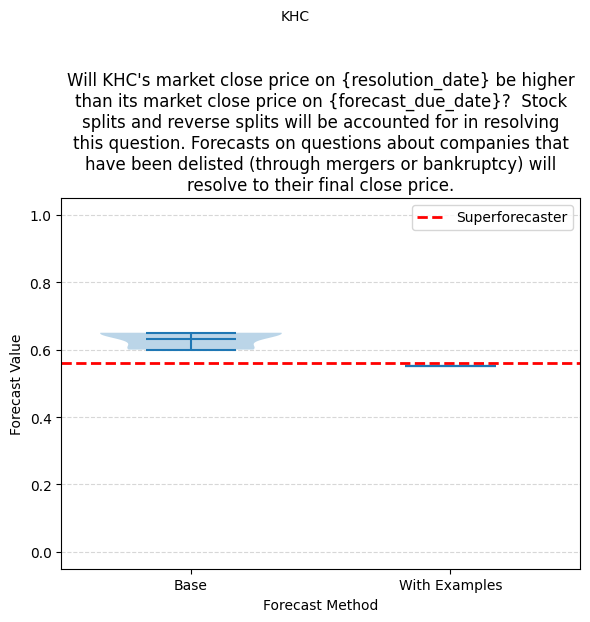

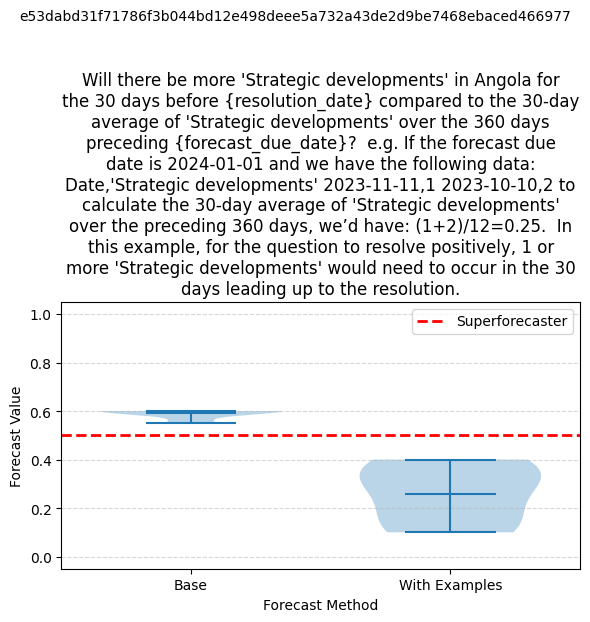

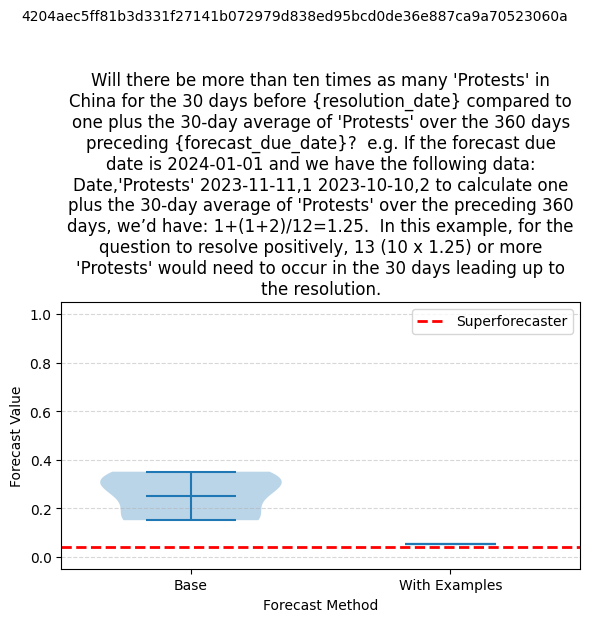

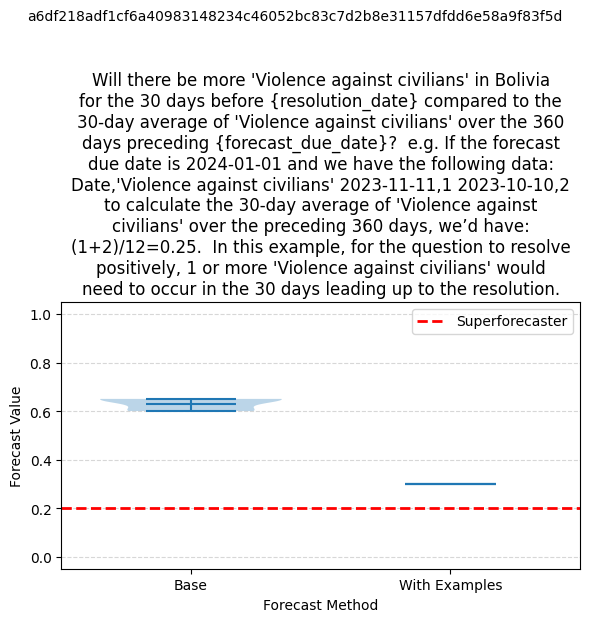

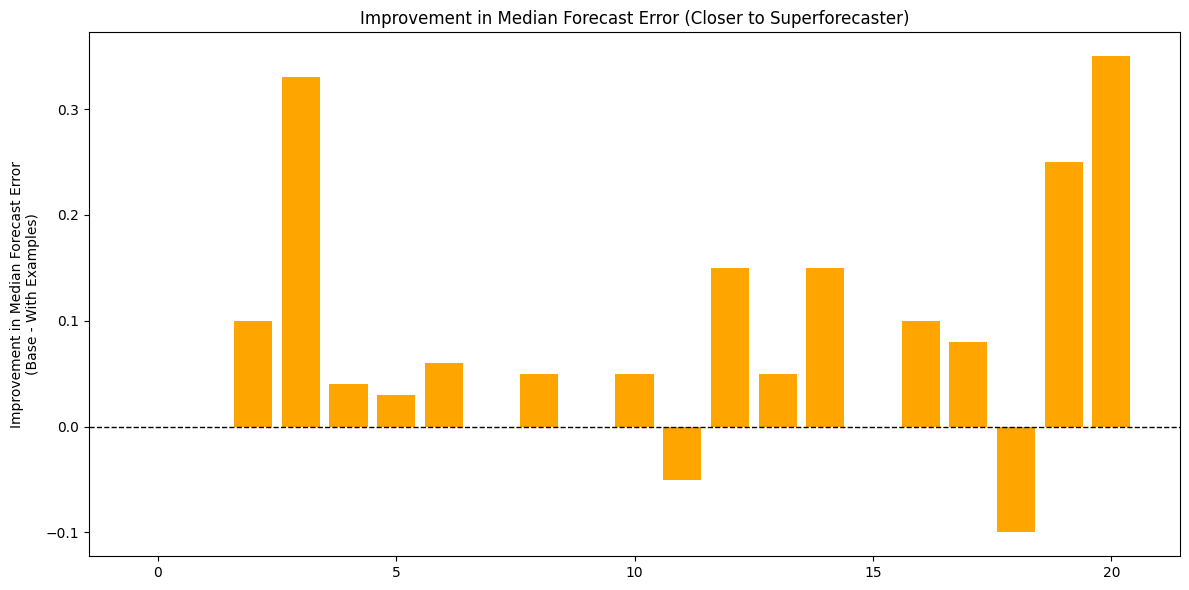

Mean improvement: 0.078
Std improvement: 0.112
Median improvement: 0.050
Mean relative improvement: 0.441
Std relative improvement: 0.512
Median relative improvement: 0.667


In [13]:
import json
import textwrap
import numpy as np

import matplotlib.pyplot as plt

resolutions_path = '/home/williaar/projects/delphi/dataset/datasets/resolution_sets/2024-07-21_resolution_set.json'

with open(resolutions_path, 'r') as f:
    resolutions_data = json.load(f)
resolutions = resolutions_data['resolutions']
resolutions[0]


for q in sampled_questions:
    qid = q.id
    # Get forecasts for both methods
    forecasts_base = []
    forecasts_examples = []
    # Find the correct entry for the selected date
    if qid in forecast_results and forecast_results[qid]['entries']:
        entry_base = forecast_results[qid]['entries'][0]
        forecasts_base = [f['forecast'] if isinstance(f, dict) and 'forecast' in f else f for f in entry_base['forecasts']]
    if qid in forecast_results_with_examples and forecast_results_with_examples[qid]['entries']:
        entry_examples = forecast_results_with_examples[qid]['entries'][0]
        forecasts_examples = [f['forecast'] if isinstance(f, dict) and 'forecast' in f else f for f in entry_examples['forecasts']]

    plt.figure(figsize=(6, 6))
    data = [forecasts_base, forecasts_examples]
    positions = [1, 2]
    parts = plt.violinplot(data, positions=positions, showmeans=True, widths=0.7)

    # Set color for "With Examples" (second violin) to orange
    # violinplot returns a dictionary with a 'bodies' key containing a list of PolyCollection objects
    if hasattr(parts, 'bodies') and len(parts.bodies) == 2:
        # First violin (base) - default color
        # Second violin (with examples) - orange
        parts.bodies[1].set_facecolor('orange')
        parts.bodies[1].set_edgecolor('orange')
        parts.bodies[1].set_alpha(0.7)

    # # Find the resolution entry for this question and date
    # resolution_value = None
    # for res in resolutions:
    #     if res['id'] == qid and res['resolution_date'] == '2024-07-28':
    #         resolution_value = res.get('resolved_to', None)
    #         break

    # if resolution_value is not None:
    #     plt.axhline(resolution_value, color='green', linestyle='--', linewidth=2, label='Ground Truth')
    #     plt.legend(loc='upper right')


    # Plot superforecaster forecast as a red dashed horizontal line if available
    sf_forecast = superforecaster_forecasts.get(qid)
    if sf_forecast is not None and hasattr(sf_forecast, 'forecast'):
        plt.axhline(sf_forecast.forecast, color='red', linestyle='--', linewidth=2, label='Superforecaster')
        plt.legend(loc='upper right')



    # Wrap the title to max 60 characters per line
    wrapped_title = "\n".join(textwrap.wrap(q.question, width=60))
    plt.title(wrapped_title)
    plt.suptitle(qid, fontsize=10, y=1.03)
    plt.xlabel('Forecast Method')
    plt.xticks(positions, ['Base', 'With Examples'])
    plt.xlim(0.5, 2.5)
    plt.ylim(-0.05, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.ylabel('Forecast Value')
    plt.tight_layout()
    plt.show()

    question_ids = []
    improvement_values = []
    relative_improvement_values = []
    titles = []

    for q in sampled_questions:
        qid = q.id
        # Get forecasts for both methods
        forecasts_base = []
        forecasts_examples = []
        if qid in forecast_results and forecast_results[qid]['entries']:
            entry_base = forecast_results[qid]['entries'][0]
            forecasts_base = [f['forecast'] if isinstance(f, dict) and 'forecast' in f else f for f in entry_base['forecasts']]
        if qid in forecast_results_with_examples and forecast_results_with_examples[qid]['entries']:
            entry_examples = forecast_results_with_examples[qid]['entries'][0]
            forecasts_examples = [f['forecast'] if isinstance(f, dict) and 'forecast' in f else f for f in entry_examples['forecasts']]

        # Only plot if superforecaster forecast exists
        sf_forecast = superforecaster_forecasts.get(qid)
        if sf_forecast is not None and hasattr(sf_forecast, 'forecast'):
            median_base = np.median(forecasts_base) if forecasts_base else np.nan
            median_examples = np.median(forecasts_examples) if forecasts_examples else np.nan
            sf_value = sf_forecast.forecast

            # Calculate improvement: reduction in absolute error (median)
            base_error = abs(median_base - sf_value)
            examples_error = abs(median_examples - sf_value)
            improvement = (base_error - examples_error)
            relative_improvement = (base_error - examples_error) / base_error if base_error != 0 else -1

            question_ids.append(qid)
            improvement_values.append(improvement)
            relative_improvement_values.append(relative_improvement)
            # Use wrapped title for readability
            titles.append("\n".join(q.id))

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(improvement_values)), improvement_values, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.xticks(range(len(improvement_values)), titles, rotation=180)
plt.ylabel('Improvement in Median Forecast Error\n(Base - With Examples)')
plt.title('Improvement in Median Forecast Error (Closer to Superforecaster)')
plt.tight_layout()
plt.show()

mean_improvement = np.mean(improvement_values)
std_improvement = np.std(improvement_values)
median_improvement = np.median(improvement_values)

print(f"Mean improvement: {mean_improvement:.3f}")
print(f"Std improvement: {std_improvement:.3f}")
print(f"Median improvement: {median_improvement:.3f}")

mean_relative_improvement = np.mean(relative_improvement_values)
std_relative_improvement = np.std(relative_improvement_values)
median_relative_improvement = np.median(relative_improvement_values)


print(f"Mean relative improvement: {mean_relative_improvement:.3f}")
print(f"Std relative improvement: {std_relative_improvement:.3f}")
print(f"Median relative improvement: {median_relative_improvement:.3f}")
